In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras import regularizers
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from tensorflow.keras.datasets import mnist



import random



In [2]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df


In [65]:
# clear_df = pd.read_pickle("../utils/data/clear_functional.pkl")
clear_df = pd.read_pickle("../utils/data/clear_functional_emovo.pkl")

# clear_df = pd.read_pickle("../utils/data/pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("../utils/data/pitch_functional_emovo.pkl")

In [66]:
labels = clear_df["label"].unique()
labels

array(['disgust', 'joy', 'neutrality', 'fear', 'anger', 'surprise',
       'sadness'], dtype=object)

In [67]:
df = []

for i,emotion in enumerate(labels):
    df.append(get_emo_df(emotion,clear_df))

Processing disgust ...
Processed 84 file for disgust
Processing joy ...
Processed 84 file for joy
Processing neutrality ...
Processed 84 file for neutrality
Processing fear ...
Processed 84 file for fear
Processing anger ...
Processed 84 file for anger
Processing surprise ...
Processed 84 file for surprise
Processing sadness ...
Processed 83 file for sadness


In [68]:
def get_data(df,seed):
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    


    X_train, X_test = train_test_split(_X, test_size=.2, random_state=seed)
    X_train, X_val = train_test_split(X_train, test_size=.1, random_state=seed)
    # print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test

In [69]:
train = []
val = []
test = []
seed = random.randint(0,100)
print(seed)
for data in df:
    tr, v, te = get_data(data, seed)
    train.append(tr)
    val.append(v)
    test.append(te)

34


In [70]:
def get_rec_error(ae, seed, flag):
    errors = {}
    for i in labels:
        errors[i] = None
    for i in range(len(labels)):
        data = df[i]
        _X_train, _X_val, _X_test = get_data(data, seed)
        if flag:
            _X_test = _X_train
        reconstructed_X = ae.predict(_X_test)
        errors[labels[i]] = mean_squared_error(_X_test,reconstructed_X)
        # mse_per_feature = ((_X_test - reconstructed_X)**2).mean(axis=0)
        # errors[labels[i]] = np.mean(mse_per_feature)
    return errors
        

In [71]:
import tensorflow as tf
# Loss personalizzata
def custom_loss(y_true, y_pred,):
    
    class_labels = y_true[:, -1]        
    original_data = y_true[:, :-1]      

    return contrastive_loss(original_data, y_pred, class_labels, alpha=1)
def contrastive_loss(y_true, y_pred, class_labels, alpha):
    """
    Funzione di loss contrastiva che:
    - Minimizza l'errore di ricostruzione per la classe target (class_labels = 1).
    - Massimizza l'errore di ricostruzione per le altre classi (class_labels = 0).
    """
   
    reconstruction_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    
    target_loss = class_labels * tf.square(reconstruction_loss)
    
   
    non_target_loss = (1.0 - class_labels) * tf.square(tf.maximum(alpha - reconstruction_loss, 0.0))
    
    
    loss_tot = target_loss + non_target_loss
    return tf.reduce_mean(loss_tot)


In [72]:
def build_autoencoder(neurons_in=28, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck'))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu'))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation=act_function, name='decoded'))
    # ac = Model(input_l,output_l)
    

    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return model

In [73]:
from datetime import datetime
class TimestampCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric_name = "duration"):
        self.__epoch_start = None
        self.__metric_name = metric_name

    def on_epoch_begin(self, epoch, logs=None):
        self.__epoch_start = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        logs[self.__metric_name] = datetime.now() - self.__epoch_start

In [74]:
  
def train_autoencoder(emotion,data_t,data_v, index):
    name = datetime.now().strftime(f"model/autoencoders/final/ae_{emotion}_%d_%m_%Y_%H_%M_%S.keras")
    print(f"training on {emotion}")
    print(f"Model name : {name}")
    ae = build_autoencoder(28,"sigmoid","adam",0)
    callbacks = [
    TimestampCallback(),
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=0,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    
    ]

    _X_train = data_t[index].to_numpy()
    _X_val = data_v[index].to_numpy()


    history = ae.fit(_X_train,_X_train,
                validation_data = (_X_val,_X_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                callbacks = callbacks)
   


    return ae, history.history["duration"]

In [94]:
#  {'act_function': 'sigmoid', 'hidden_layers': 0, 'neurons_in': 64, 'optimizer': 'Adam'}

# seed = 23
# seed = 99

In [75]:
def compute_dur(duration):
    tot = 0
    for i in range(len(duration)):
        tot += duration[i].microseconds / 1000

    return tot / i, i

In [76]:
autoencoders = []
durations = []
for i,emotion in enumerate(labels):
    # autoencoders.append(train_autoencoder(emotion, df[i], i))
    autoencoders.append(train_autoencoder(emotion, train, val, i)[0])
    durations.append(train_autoencoder(emotion, train, val, i)[1])

training on disgust
Model name : model/autoencoders/final/ae_disgust_03_12_2024_15_31_32.keras
training on disgust
Model name : model/autoencoders/final/ae_disgust_03_12_2024_15_31_56.keras
training on joy
Model name : model/autoencoders/final/ae_joy_03_12_2024_15_32_20.keras
training on joy
Model name : model/autoencoders/final/ae_joy_03_12_2024_15_32_47.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_03_12_2024_15_33_12.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_03_12_2024_15_33_41.keras
training on fear
Model name : model/autoencoders/final/ae_fear_03_12_2024_15_34_03.keras
training on fear
Model name : model/autoencoders/final/ae_fear_03_12_2024_15_34_29.keras
training on anger
Model name : model/autoencoders/final/ae_anger_03_12_2024_15_35_00.keras
training on anger
Model name : model/autoencoders/final/ae_anger_03_12_2024_15_35_38.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_03_

In [64]:
print("DEMoS")
tot_dur = []
tot_epochs = []
for i, label in enumerate(labels): 
    print(f"{label}: ")
    print(f"Mean time: {compute_dur(durations[i])[0]:.2f}, Total epochs : {compute_dur(durations[i])[1]}")
    tot_dur.append(compute_dur(durations[i])[0])
    tot_epochs.append(compute_dur(durations[i])[1])


print(f"Mean epoch time : {np.mean(tot_dur):.2f}, mean epoch tot : {np.mean(tot_epochs)}")

DEMoS
neutral: 
Mean time: 36.48, Total epochs : 411
guilt: 
Mean time: 37.94, Total epochs : 248
disgust: 
Mean time: 42.50, Total epochs : 182
happiness: 
Mean time: 39.71, Total epochs : 228
fear: 
Mean time: 38.93, Total epochs : 237
anger: 
Mean time: 41.29, Total epochs : 248
surprise: 
Mean time: 36.80, Total epochs : 282
sadness: 
Mean time: 40.50, Total epochs : 260
Mean epoch time : 39.27, mean epoch tot : 262.0


In [77]:
print("EMOVO")
tot_dur = []
tot_epochs = []
for i, label in enumerate(labels): 
    print(f"{label}: ")
    print(f"Mean time: {compute_dur(durations[i])[0]:.2f}, Total epochs : {compute_dur(durations[i])[1]}")
    tot_dur.append(compute_dur(durations[i])[0])
    tot_epochs.append(compute_dur(durations[i])[1])


print(f"Mean epoch time : {np.mean(tot_dur):.2f}, mean epoch tot : {np.mean(tot_epochs)}")

EMOVO
disgust: 
Mean time: 33.52, Total epochs : 506
joy: 
Mean time: 35.05, Total epochs : 505
neutrality: 
Mean time: 33.03, Total epochs : 467
fear: 
Mean time: 42.30, Total epochs : 502
anger: 
Mean time: 42.38, Total epochs : 586
surprise: 
Mean time: 43.27, Total epochs : 586
sadness: 
Mean time: 43.88, Total epochs : 553
Mean epoch time : 39.06, mean epoch tot : 529.2857142857143


In [21]:
dict_errors = {}
for i in labels:
    dict_errors[i] = None
for i in range(len(autoencoders)):
    dict_errors[labels[i]] = get_rec_error(autoencoders[i], seed,0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━

In [34]:
dict_errors["anger"]["disgust"]

0.04368724

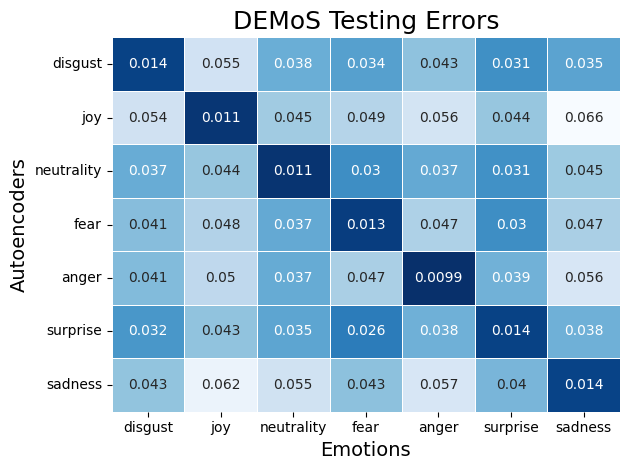

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
table = pd.DataFrame.from_dict(dict_errors, orient='index')
fig = plt.figure(facecolor='w', edgecolor='k')
ax = sns.heatmap(table, annot=True, cmap='Blues_r', cbar=False, linewidths=.5) 
ax.set_xlabel('Emotions', fontsize=14)
ax.set_ylabel('Autoencoders', fontsize=14)
ax.set_title('DEMoS Testing Errors', fontsize=18)

plt.tight_layout()
plt.savefig('../utils/DEMoS_Testing_errors.png')

In [23]:
def make_prediction(X_test):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    _er = []
    y_pred = []
    for encoder in autoencoders:
        _er.append(mean_squared_error(X_test,encoder.predict(X_test.reshape(-1,88), verbose=0).reshape(88,)))
    y_pred.append(np.argmin(_er))
    print(y_pred)

In [17]:
from sklearn.metrics import mean_squared_error

def obtain_predictions(test, autoencoders):
    y_true = []

    y_pred = []
    errors = []
    _test = []
    for n in range(len(test)):
        _test.append(test[n].to_numpy())
    for n in tqdm(range(len(df))):
        X_test = _test[n]
        cls = []

        for i in (range(len(X_test))):
            _er = []
            for encoder in autoencoders:
            #print(labels[x])
                _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,88), verbose=0).reshape(88,)))
            errors.append(_er)
            y_pred.append(np.argmin(_er))
            y_true.append(n)
    return errors, y_true, y_pred

    #pred.append(cls)
    # print(cls)

In [14]:
def obtain_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true,y_pred)

    g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
    g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
    g.set_xlabel("Predicted Label", fontsize=14)
    g.set_ylabel("True Label", fontsize = 14)
    g.set_title(title)
    
    name = title + ".png"
    plt.tight_layout()
    plt.show()
    g.figure.savefig(name)

# g.set_title(data, fontsize = 18)

In [15]:
def sort_errors(data, y_true):
    emo = []

    array_dati = np.array(data)
    array_indici = np.array(y_true)


# Iteriamo sugli indici unici in array_indici
    for indice_unico in np.unique(array_indici):
    # Troviamo le posizioni degli indici uguali all'indice unico
        posizioni = np.where(array_indici == indice_unico)[0]
    
    # Selezioniamo le righe corrispondenti da array_dati
        righe_selezionate = array_dati[posizioni]
    
    # Aggiungiamo le righe selezionate alla lista principale
        emo.append(np.array(righe_selezionate.tolist()))
    return emo


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]


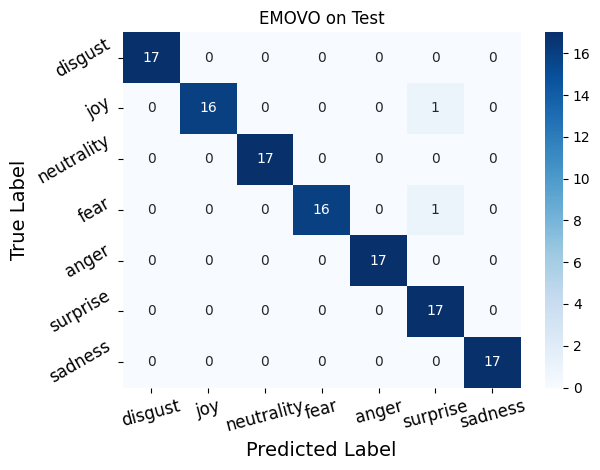

In [34]:
train_errors, y_true, y_pred = obtain_predictions(test, autoencoders)
obtain_cm(y_true, y_pred, labels, "EMOVO on Test")

In [ ]:
import pickle

# with open('train_errors_DEMOS.pkl', 'wb') as handle:
#     pickle.dump(train_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('y_true_train_DEMoS.pkl', 'wb') as handle:
#     pickle.dump(y_true, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('y_pred_train_DEMoS.pkl', 'wb') as handle:
#     pickle.dump(y_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)


with open('..\utils\paper\data\test_errors_DEMOS.pkl', 'rb') as handle:
    b = pickle.load(handle)

print(train_errors == b) 

with open('y_true_train_DEMoS.pkl', 'rb') as handle:
    b = pickle.load(handle)

print(y_true == b)
with open('y_pred_train_DEMoS.pkl', 'rb') as handle:
    b = pickle.load(handle)

print(y_pred == b )

True
True
True


In [9]:
import pickle 

with open('../utils/paper/data/test_errors_DEMOS.pkl', 'rb') as handle:
    test_errors = pickle.load(handle)


with open('../utils/paper/data/y_true_test_DEMoS.pkl', 'rb') as handle:
    y_true_test_DEMoS = pickle.load(handle)


with open('../utils/paper/data/y_pred_test_DEMoS.pkl', 'rb') as handle:
    y_pred_test_DEMoS = pickle.load(handle)

In [ ]:
from sklearn.metrics import recall_score

recall_score(y_true_test_DEMoS, y_pred_test_DEMoS, average='macro')

In [93]:
train_errros = sort_errors(train_errors, y_true)

In [121]:
emo = []

array_dati = np.array(train_errors)
array_indici = np.array(y_true)


# Iteriamo sugli indici unici in array_indici
for indice_unico in np.unique(array_indici):
# Troviamo le posizioni degli indici uguali all'indice unico
    posizioni = np.where(array_indici == indice_unico)[0]

# Selezioniamo le righe corrispondenti da array_dati
    righe_selezionate = array_dati[posizioni]

# Aggiungiamo le righe selezionate alla lista principale
    emo.append((righe_selezionate.tolist()))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

17

In [144]:
test_errors, y_true, y_pred = obtain_predictions(test, autoencoders)
emo = []

array_dati = np.array(test_errors)
array_indici = np.array(y_true)


# Iteriamo sugli indici unici in array_indici
for indice_unico in np.unique(array_indici):
# Troviamo le posizioni degli indici uguali all'indice unico
    posizioni = np.where(array_indici == indice_unico)[0]

# Selezioniamo le righe corrispondenti da array_dati
    righe_selezionate = array_dati[posizioni]

# Aggiungiamo le righe selezionate alla lista principale
    emo.append(np.array(righe_selezionate.tolist()))


with open('data_test_opt_emovo.pkl', 'wb') as handle:
    pickle.dump(emo, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data_test_opt_emovo.pkl', 'rb') as handle:
    b = pickle.load(handle)


# print(emo == b)

if len(emo) != len(b):
    print(False)

for arr1, arr2 in zip(emo, b):
    if not np.array_equal(arr1, arr2):
        print(False)

print("Ultimo True")

Ultimo True


In [ ]:
test_errors, y_true, y_pred = obtain_predictions(test, autoencoders)
test_errors_np = sort_errors(test_errors, y_true)

with open('data_test_opt_emovo.pkl', 'wb') as handle:
    pickle.dump(test_errors_np, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data_test_opt_emovo.pkl', 'rb') as handle:
    b = pickle.load(handle)


print(test_errors_np == b)

if len(test_errors_np) != len(b):
    print(False)

for arr1, arr2 in zip(test_errors_np, b):
    if not np.array_equal(arr1, arr2):
        print(False)

print("Ultimo True")


True
Ultimo True


In [140]:
test_errors_np[0][:,0]

TypeError: list indices must be integers or slices, not tuple

In [133]:
prova = []
for i in range(len(test_errors_np[0])):
    prova.append(np.array(test_errors_np[0][i]))

In [139]:
prova[0][:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [160]:
import pickle
train_errors, y_true, y_pred = obtain_predictions(train, autoencoders)
train_errors = sort_errors(train_errors, y_true)



with open('data_train_opt_demos.pkl', 'wb') as handle:
    pickle.dump(train_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data_train_opt_demos.pkl', 'rb') as handle:
    b = pickle.load(handle)

if len(train_errors) != len(b):
    print(False)

for arr1, arr2 in zip(train_errors, b):
    if not np.array_equal(arr1, arr2):
        print(False)

print("Ultimo True")

test_errors, y_true, y_pred = obtain_predictions(test, autoencoders)
test_errors = sort_errors(test_errors, y_true)


with open('data_test_opt_demos.pkl', 'wb') as handle:
    pickle.dump(test_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data_test_opt_demos.pkl', 'rb') as handle:
    b = pickle.load(handle)

if len(test_errors) != len(b):
    print(False)

for arr1, arr2 in zip(test_errors, b):
    if not np.array_equal(arr1, arr2):
        print(False)

print("Ultimo True")

Ultimo True
Ultimo True


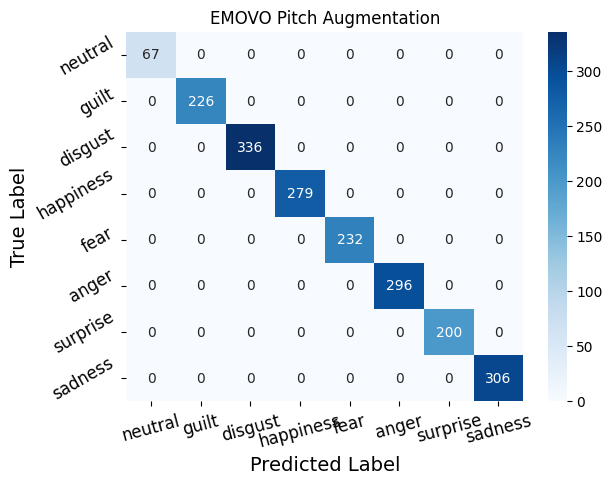

1.0
1.0


In [112]:
y_true, y_pred = obtain_predictions(test, autoencoders)

obtain_cm(y_true, y_pred, labels)
print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average ="weighted"))

In [30]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average ="weighted")
print(f"Accuracy : {accuracy_score(y_true, y_pred)}")
print(f"F1 score : {f1_score(y_true, y_pred, average ="weighted")}")
print(classification_report(y_true, y_pred, target_names=labels))

Accuracy : 0.9831932773109243
F1 score : 0.9831860016733966
              precision    recall  f1-score   support

     disgust       1.00      0.94      0.97        17
         joy       1.00      1.00      1.00        17
  neutrality       1.00      1.00      1.00        17
        fear       0.94      0.94      0.94        17
       anger       1.00      1.00      1.00        17
    surprise       0.94      1.00      0.97        17
     sadness       1.00      1.00      1.00        17

    accuracy                           0.98       119
   macro avg       0.98      0.98      0.98       119
weighted avg       0.98      0.98      0.98       119



In [36]:
f1 = []
accuracy = []
aur = []
for i in tqdm(range(10)):
    train = []
    val = []
    test = []
    seed = random.randint(0,100)
    print(seed)
    for data in df:
        tr, v, te = get_data(data, seed)
        train.append(tr)
        val.append(v)
        test.append(te)
    autoencoders = []
    for i,emotion in enumerate(labels):
        # autoencoders.append(train_autoencoder(emotion, df[i], i))
        autoencoders.append(train_autoencoder(emotion, train, val, i))
    errors, y_true, y_pred = obtain_predictions(test, autoencoders)

    # obtain_cm(y_true, y_pred, labels)
    aur.append(recall_score(y_true, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_true, y_pred))
    f1.append(f1_score(y_true, y_pred, average ="weighted"))
    # print(f"Accuracy : {accuracy_score(y_true, y_pred)}")
    # print(f"F1 score : {f1_score(y_true, y_pred, average ="weighted")}")
    # print(classification_report(y_true, y_pred, target_names=labels))

  0%|          | 0/10 [00:00<?, ?it/s]

28
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_12_37_52.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_12_38_28.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_12_39_07.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_12_39_48.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_12_40_24.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_12_40_59.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_12_41_36.keras


 10%|█         | 1/10 [04:54<44:09, 294.34s/it]

0
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_12_42_46.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_12_43_17.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_12_44_01.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_12_44_39.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_12_45_10.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_12_45_46.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_12_46_30.keras


 20%|██        | 2/10 [09:49<39:16, 294.59s/it]

47
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_12_47_41.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_12_48_16.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_12_48_46.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_12_49_16.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_12_49_48.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_12_50_24.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_12_50_55.keras


 30%|███       | 3/10 [14:14<32:49, 281.36s/it]

7
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_12_52_06.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_12_52_35.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_12_53_14.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_12_53_56.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_12_54_21.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_12_54_54.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_12_55_25.keras


 40%|████      | 4/10 [18:36<27:22, 273.69s/it]

50
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_12_56_28.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_12_57_00.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_12_57_34.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_12_58_16.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_12_58_50.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_12_59_19.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_12_59_49.keras


 50%|█████     | 5/10 [23:16<22:59, 275.81s/it]

41
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_13_01_08.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_13_01_38.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_13_02_08.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_13_02_38.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_13_03_03.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_13_03_34.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_13_04_06.keras


 60%|██████    | 6/10 [27:12<17:29, 262.35s/it]

64
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_13_05_04.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_13_05_35.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_13_06_06.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_13_06_34.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_13_07_01.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_13_07_26.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_13_07_55.keras


 70%|███████   | 7/10 [30:57<12:30, 250.26s/it]

85
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_13_08_50.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_13_09_14.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_13_09_39.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_13_10_03.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_13_10_36.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_13_10_57.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_13_11_26.keras


 80%|████████  | 8/10 [34:32<07:57, 238.97s/it]

10
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_13_12_24.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_13_12_50.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_13_13_23.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_13_13_52.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_13_14_18.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_13_14_49.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_13_15_21.keras


 90%|█████████ | 9/10 [38:21<03:55, 235.90s/it]

7
training on disgust
Model name : model/autoencoders/final/ae_disgust_26_11_2024_13_16_13.keras
training on joy
Model name : model/autoencoders/final/ae_joy_26_11_2024_13_16_36.keras
training on neutrality
Model name : model/autoencoders/final/ae_neutrality_26_11_2024_13_16_58.keras
training on fear
Model name : model/autoencoders/final/ae_fear_26_11_2024_13_17_32.keras
training on anger
Model name : model/autoencoders/final/ae_anger_26_11_2024_13_17_51.keras
training on surprise
Model name : model/autoencoders/final/ae_surprise_26_11_2024_13_18_13.keras
training on sadness
Model name : model/autoencoders/final/ae_sadness_26_11_2024_13_18_43.keras


100%|██████████| 10/10 [41:42<00:00, 250.24s/it]


In [37]:
print(f"EMOVO - F1 : {np.mean(f1), np.std(f1)},  Acc : {np.mean(accuracy), np.std(accuracy)} - AUR : {np.mean(aur), np.std(aur)}")

EMOVO - F1 : (0.9907896143715471, 0.00868423313972871),  Acc : (0.9907563025210084, 0.008773366814210565) - AUR : (0.9907563025210084, 0.008773366814210514)


In [22]:
print(f"DEMoS - F1 : {np.mean(f1), np.std(f1)},  Acc : {np.mean(accuracy), np.std(accuracy)} - AUR : {np.mean(aur), np.std(aur)}")

DEMoS - F1 : (0.9990215239028905, 0.000628475532948038),  Acc : (0.9990216271884655, 0.0006285559019430379) - AUR : (0.9986428720537168, 0.0012526431989410604)


# Optimization

## GRID SEARCH

In [52]:
def build_autoencoder(neurons_in=16, act_function="sigmoid", optimizer="adam", hidden_layers=1):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))


    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

    model.add(Dense(neurons_in, activation='relu', name='bottleneck', kernel_regularizer=keras.regularizers.l2(0.1)))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hidden_layers):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation=act_function, name='output_l'))
    # ac = Model(input_l,output_l)
    
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[keras.metrics.mean_squared_error(name="mse")])
    
    return model

In [56]:
from sklearn.metrics import mean_squared_error


def score_func(y, y_pred):
    error = mean_squared_error(y, y_pred)
    print(error)
    return error

from sklearn.metrics import make_scorer
recon_error = make_scorer(score_func, greater_is_better=False)

In [60]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


# param_grid = [{'neurons_in':[2**4,2**3, 2**2], "act_function" : ["sigmoid", "relu", "leaky_relu", 'tanh'], "optimizer" : ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']}]
neurons_in = [2**4,2**3, 2**2]
act_function = ["sigmoid", "relu", "leaky_relu", 'tanh']
loss = ["binary_crossentropy"]
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax', 'Nadam']
hidden_layers = [0,1,2]

param_grid = dict(neurons_in = [2**5, 2**4,2**3, 2**2], act_function = ["sigmoid"], optimizer = ['Adam'], hidden_layers = [0,1,2])
callbacks = [
keras.callbacks.EarlyStopping(  
    monitor="val_loss",
    min_delta=0.001,
    patience=40,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)
]
# , act_function = act_function, optimizer=optimizer

autoencoder_base = KerasRegressor(build_autoencoder, verbose=3, neurons_in = 16, act_function = "sigmoid", optimizer="adam", hidden_layers = 0, loss ="binary_crossentropy")
# Esegui la grid search
grid = GridSearchCV(estimator=autoencoder_base, param_grid=param_grid, n_jobs=-1, cv=10, verbose=3, scoring=recon_error)
history = grid.fit(train[0].to_numpy(),train[0].to_numpy(),
                   epochs=2000,
                   batch_size=128, 
                   shuffle=True,
                   validation_data=(val[0].to_numpy(),val[0].to_numpy()),   
                   callbacks = callbacks)

gs_results = history.cv_results_


print('\n\n CV results:')

for mean_score, params in zip(gs_results['mean_test_score'],gs_results['params']):
    print(mean_score,params)

best_params = history.best_params_
best_score = history.best_score_

print(f"\n\n The best Hyperparameter combination is:\n {best_params} \n with a mean test score of: {best_score}") 

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68

## BAYESIAN KERAS TUNER

In [ ]:
import kerastuner as kt

In [79]:
def build_autoencoder_opt(hp):
    model = keras.Sequential()
    model.add(Input(shape= (88,)))

    neurons_in = hp.Int("neuron_code", min_value = 4, max_value = 28, step = 8)

    for i in range(hp.Int('hidden_1',min_value = 0, max_value = 2, default=0)):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    

    # encoded_l1 = Dense(neurons_in*4, activation='relu', name='encoded_1')(input_l) 
    # encoded_l2 = Dense(neurons_in*2, activation='relu', name='encoded_2')(input_l)
    # encoded_l3 = Dense(20, activation='relu', name='encoded_3')(encoded_l2)

  #   neurons_in = hp.Int("neuron_code", min_value = 2**2, max_value = 2**5, step = 10)
    model.add(Dense(neurons_in, activation='relu', name='bottleneck', kernel_regularizer=keras.regularizers.l2(0.1)))

    # decoded_l1 = Dense(20, activation='relu', name='decoded_3')(bottleneck)
    # decoded_l2 = Dense(neurons_in*2, activation='relu', name='decoded_4')(bottleneck)
    # decoded_l3 = Dense(neurons_in*4, activation='relu', name='decoded_5')(decoded_l2)

    for i in range(hp.Int('hidden_2',min_value = 0, max_value = 2, default=0)):
        model.add(Dense(neurons_in*(2*(i+1)), activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
    # Dense(88, activation=act_function, name='output_l')(decoded_l3)
    model.add(Dense(88, activation="sigmoid", name='output_l'))
    # ac = Model(input_l,output_l)
    
    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=[keras.metrics.MeanSquaredError(name="mse")])
    
    return model


In [80]:
tuner = kt.BayesianOptimization(
    build_autoencoder_opt,
    objective=kt.Objective("val_mse", direction="min"),
    max_trials=50,
    project_name= "AE_OPT",
    overwrite=True)

In [66]:
callbacks = [keras.callbacks.EarlyStopping(  
    monitor="val_loss",
    min_delta=0.001,
    patience=40,
    verbose=0,
    mode="auto",
    restore_best_weights=True
)
]
# , act_function = act_function, optimizer=optimizer
tuner.search(train[0].to_numpy(),train[0].to_numpy(),
                   epochs=2000,
                   batch_size=128, 
                   shuffle=True,
                   validation_data=(val[0].to_numpy(),val[0].to_numpy()),   
                   callbacks = callbacks)

Trial 50 Complete [00h 01m 03s]
val_mse: 0.03690607100725174

Best val_mse So Far: 0.03467835113406181
Total elapsed time: 00h 51m 02s


In [76]:
# Get the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(1)[0]

# get the best model
# best_model = tuner.get_best_models(1)[0]

In [47]:
best_hps = tuner.get_best_hyperparameters(num_trials=5)[0]

In [78]:
print(best_hps.get("neuron_code"))
print(best_hps.get("hidden_1"))
print(best_hps.get("hidden_2"))

28
0
0


In [77]:
best_hps

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.fit(train[0].to_numpy(),train[0].to_numpy(),
                   epochs=2000,
                   batch_size=128, 
                   shuffle=True,
                   validation_data=(val[0].to_numpy(),val[0].to_numpy()),   
                   callbacks = callbacks)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: 4.8499 - mse: 0.0826 - val_loss: 4.7903 - val_mse: 0.0891
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7935 - mse: 0.0819 - val_loss: 4.7349 - val_mse: 0.0886
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.7377 - mse: 0.0812 - val_loss: 4.6801 - val_mse: 0.0882
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.6825 - mse: 0.0805 - val_loss: 4.6258 - val_mse: 0.0877
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.6278 - mse: 0.0799 - val_loss: 4.5720 - val_mse: 0.0873
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.5737 - mse: 0.0792 - val_loss: 4.5188 - val_mse: 0.0868
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4.5201 - mse: 0.0786 - val_loss: 4.4661 - val_mse: 0.0864
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 4.4671 - mse: 0.0780 - val_loss: 4.4140 - val_mse: 0.0860
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.41

In [71]:
get_rec_error(model, seed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


{'disgust': 0.023229005,
 'joy': 0.06494438,
 'neutrality': 0.050938036,
 'fear': 0.045492902,
 'anger': 0.05174005,
 'surprise': 0.040738687,
 'sadness': 0.050226733}

# EXTRA

In [ ]:
sad = []

for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "sadness" in name:
        sad.append(id)


mask = clear_df['filename'].isin(sad)
sad_df = clear_df[mask].reset_index()
sad_df = sad_df.drop(['index'], axis=1)

happiness_df = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "happiness" in name:
        happiness_df.append(id)


mask = clear_df['filename'].isin(happiness_df)
happiness_df = clear_df[mask].reset_index()
happiness_df = happiness_df.drop(['index'], axis=1)

guilt = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "guilt" in name:
        guilt.append(id)


mask = clear_df['filename'].isin(guilt)
guilt_df = clear_df[mask].reset_index()
guilt_df = guilt_df.drop(['index'], axis=1)

disgust = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "disgust" in name:
        disgust.append(id)


mask = clear_df['filename'].isin(disgust)
disgust_df = clear_df[mask].reset_index()
disgust_df = disgust_df.drop(['index'], axis=1)

fear = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "fear" in name:
        fear.append(id)


mask = clear_df['filename'].isin(fear)
fear_df = clear_df[mask].reset_index()
fear_df = fear_df.drop(['index'], axis=1)

anger = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "anger" in name:
        anger.append(id)


mask = clear_df['filename'].isin(anger)
anger_df = clear_df[mask].reset_index()
anger_df = anger_df.drop(['index'], axis=1)

surprise = []


for id, name in zip(clear_df["filename"],clear_df["label"]):
    if "surprise" in name:
        surprise.append(id)


mask = clear_df['filename'].isin(surprise)
surprise_df = clear_df[mask].reset_index()
surprise_df = surprise_df.drop(['index'], axis=1)